In [1]:
import functools
import numpy as np
import jax 
import optax
import haiku as hk
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk',font_scale=1.0)

import utils

In [2]:
%matplotlib inline

## Generate Data

In [3]:
def load_dataset(x_range, b0, w0, n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    # y = (w0 * x * (1 + np.sin(x)) + b0) + eps
    y = (w0 * x * (1 + np.sin(x)) + b0) + eps
    y = (y-y.mean()) / y.std()
    xm, xs = x.mean(), x.std()
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y.astype(np.float32), ((x-xm)/xs).astype(np.float32), ((x_tst-xm)/xs).astype(np.float32)

def dataset(x, y, batch_size):
    ids = np.arange(len(x))
    while True:
        ids = np.random.choice(ids, batch_size, False)
        yield x[ids].astype(np.float32), y[ids].astype(np.float32)
        
w0 = 0.125
b0 = 0.
x_range = [-20, 60]
batch_size = 32
y, x, x_tst = load_dataset(x_range, b0, w0)
data = iter(dataset(x, y, batch_size))

## Plotting

In [4]:
def plot(x_range, x, y, x_tst, yhats):
    plt.figure(figsize=[15, 4.0], dpi= 100)  # inches
    plt.plot(x, y, 'b.', label='observed')

    avgm = np.zeros_like(x_tst[..., 0])
    for i, yhat in enumerate(yhats):
        m = np.squeeze(yhat.mean())
        s = np.squeeze(yhat.stddev())
        if i < 15:
            plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
            plt.plot(x_tst, m + 3 * s, 'g', linewidth=0.5, label='ensemble means + 3 ensemble stdev' if i == 0 else None)
            plt.plot(x_tst, m - 3 * s, 'g', linewidth=0.5, label='ensemble means - 3 ensemble stdev' if i == 0 else None)
        avgm += m
    plt.plot(x_tst, avgm / len(yhats), 'r', label='overall mean', linewidth=4)
    #plt.ylim(-7+b0, 17+b0)
    #plt.yticks(np.linspace(0, 15, 4)[1:])
    #plt.xticks(np.linspace(*x_range, num=9))
    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(0.95, 0.5))
    plt.tight_layout()
    #plt.show()

## Prior Predictive Check

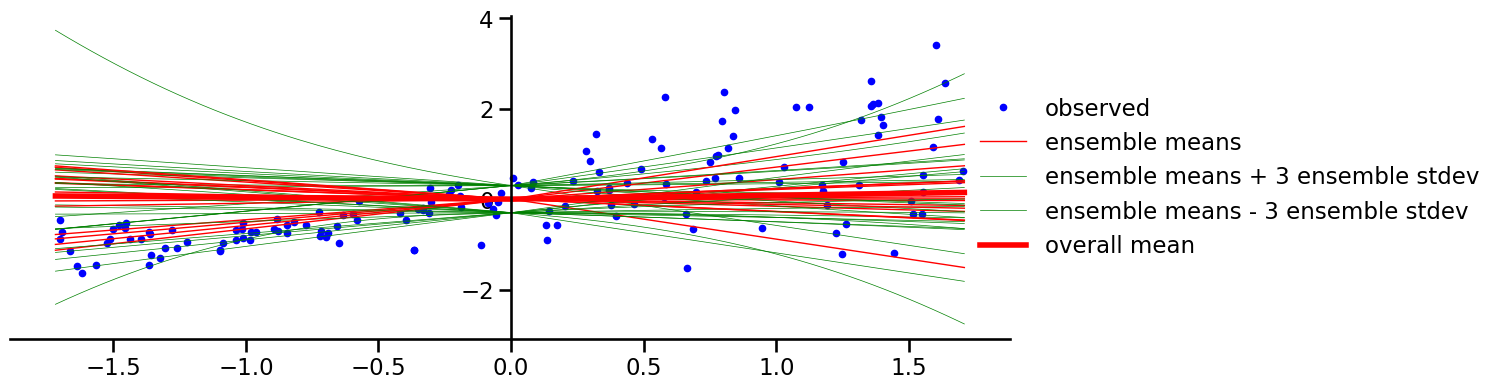

In [5]:
from f_povi import FunctionalParticleOptimization
net_fn = functools.partial(utils.net, n_layers=2, n_hidden=50)
model = FunctionalParticleOptimization(x[:batch_size], 20, net_fn)
plot(x_range, x, y, x_tst, model.predict(x_tst))

## Train with Bayes-by-Backprop

In [6]:
if False:  # TODO: I've changed the behavior of utils.net, so BBB may need fixing
    from bayes_by_backprop import BayesByBackprop
    model = BayesByBackprop(x[:batch_size], 20, net_fn)
    opt = optax.flatten(optax.adam(0.01))
    keys = hk.PRNGSequence(jax.random.PRNGKey(42))

    @jax.jit
    def update(x, y, params, key, opt_state):
        grads = model.update_step(params, key, x, y)
        updates, new_opt_state = opt.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state

    opt_state = opt.init(model.params)

    for step in range(10000):
        model.params, opt_state = update(*next(data), model.params, next(keys),
                                     opt_state)
    yhats_bbb = model.predict(x_tst)
    plot(x_range, x, y, x_tst, yhats_bbb)

## Train with Functional Particle Optimization

(-3.0, 3.0)

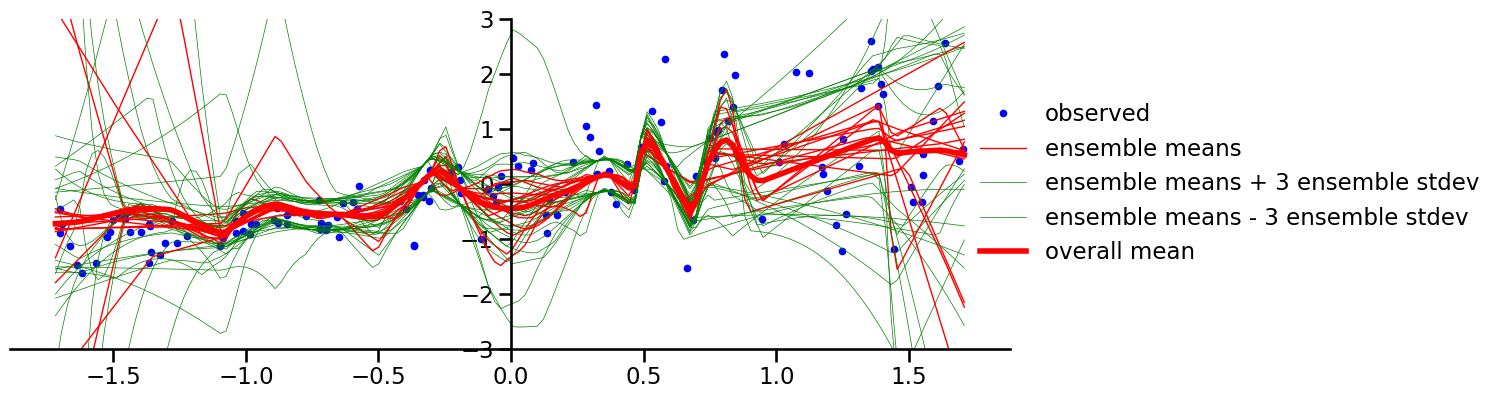

In [7]:
model = FunctionalParticleOptimization(x[:batch_size], 20, net_fn, n_prior_particles=80)
opt = optax.flatten(optax.adam(1e-3))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys),
                                     opt_state)
yhats_fpovi = model.predict(x_tst)
plot(x_range, x, y, x_tst, yhats_fpovi)
plt.ylim(-3, 3)
#plt.title('approximate posterior')

The approximate posterior appears to be underfitting in the $x\in (1,2)$ region. The following experiment with point estimation suggests this may be due to the limited capacity of the NN architecture:

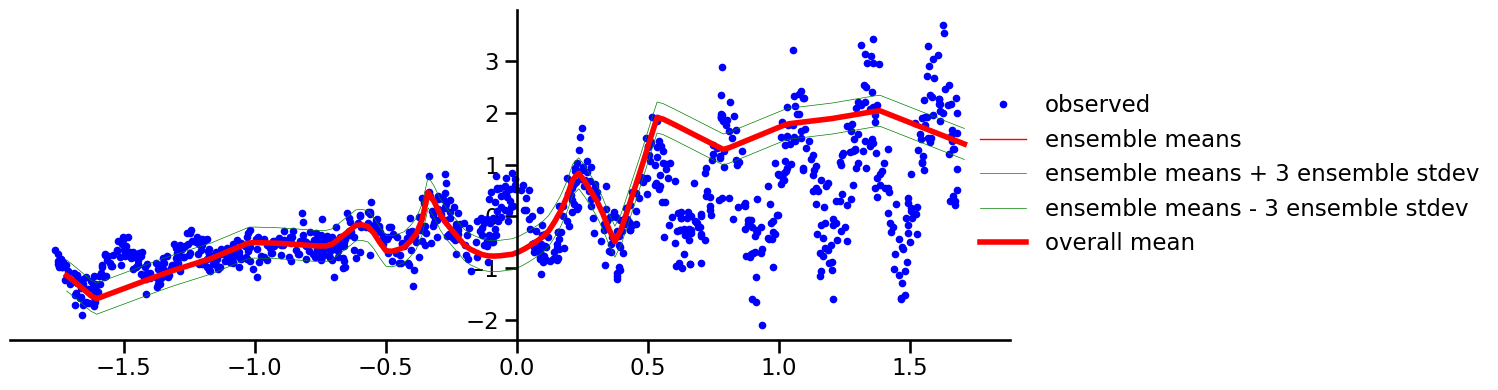

In [8]:
yl, xl = load_dataset(x_range, b0, w0, n=1000)[:2]
large_data = iter(dataset(xl, yl, batch_size))

model = FunctionalParticleOptimization(
    xl[:batch_size], 1,
    functools.partial(utils.net, n_layers=2, n_hidden=100, sd_min=0.1, sd_max=0.1))
def vacuous_prior(inp):
    class A:
        def log_prob(self, inp):
            return jax.numpy.zeros((inp.shape[0],))
    return A()
model._prior = vacuous_prior
opt = optax.flatten(optax.adam(0.004))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(10000):
    model.params, opt_state = update(*next(large_data), model.params, next(keys),
                                     opt_state)
yhats_fpovi = model.predict(x_tst)
plot(x_range, xl, yl, x_tst, yhats_fpovi)
#plt.ylim(-5, 5)
#plt.title('approximate posterior')

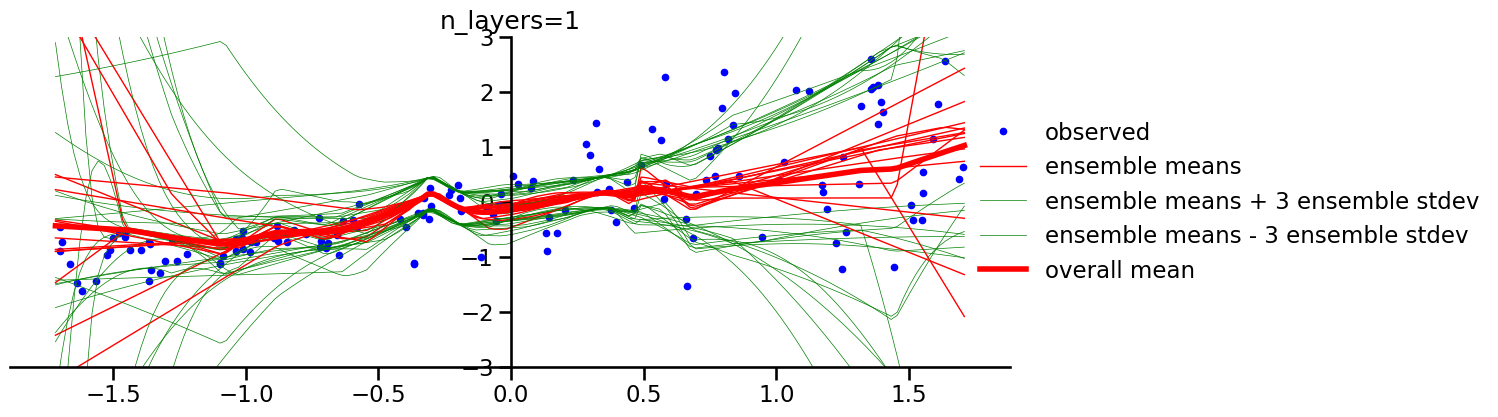

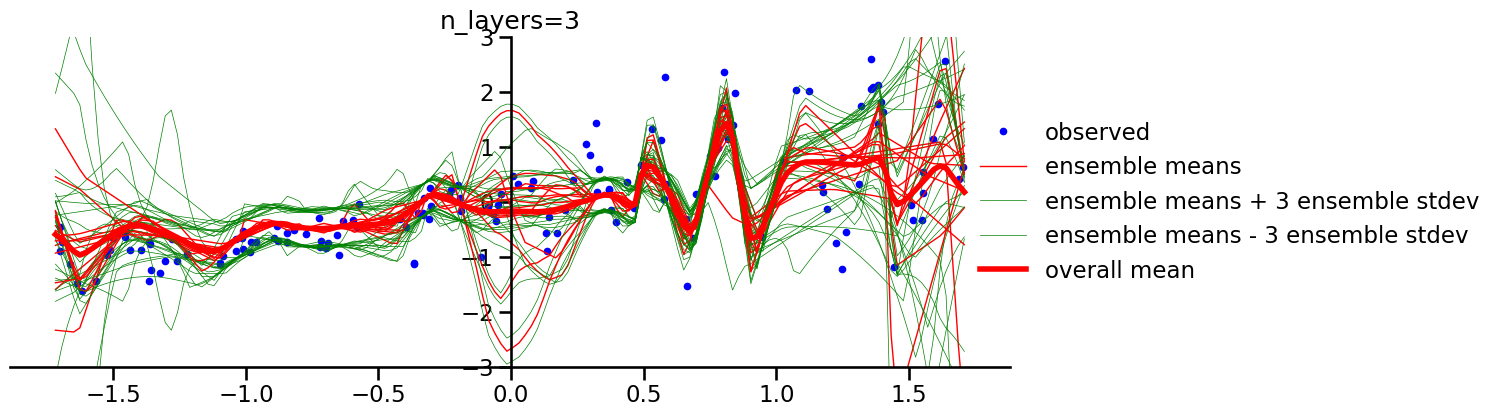

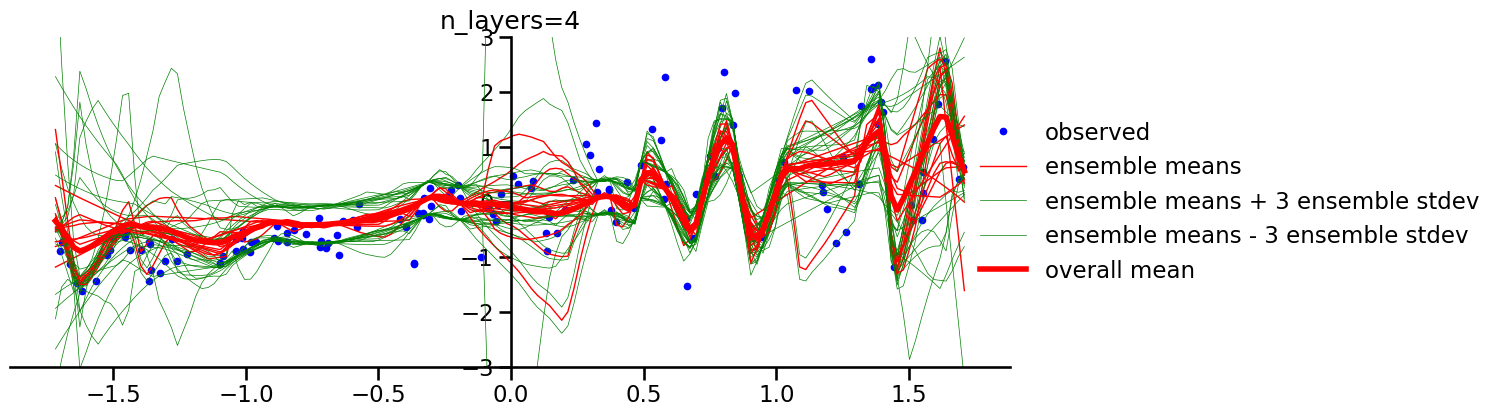

In [9]:
for n_layers in [1, 3, 4]:
    model = FunctionalParticleOptimization(x[:batch_size], 20, functools.partial(utils.net, n_layers=n_layers), n_prior_particles=80)
    opt = optax.flatten(optax.adam(1e-3))
    keys = hk.PRNGSequence(jax.random.PRNGKey(42))
    opt_state = opt.init(model.params)

    for step in range(20000):
        model.params, opt_state = update(*next(data), model.params, next(keys),
                                         opt_state)
    yhats_fpovi = model.predict(x_tst)
    plot(x_range, x, y, x_tst, yhats_fpovi)
    plt.ylim(-3, 3)
    plt.title(f'{n_layers=}')